# Electra
### 220220018 천호진

Electra는 Bert와 같은 MLM 모델보다 연산량 대비 높은 성능을 내는 언어 모델이다. <br>
Bert같은 MLM 모델은 다음 단점들이 있다.
- 마스킹된 토큰 사이의 상관관계를 학습할 수 없다.
- 전체 시퀀스중 약 15%의 마스킹된 토큰에 대해서만 학습이 이루어져 비효율적이다.
- 모델이 학습될 때는 Mask 토큰을 보지만 추론할 때는 Mask 토큰을 보지 않는다.

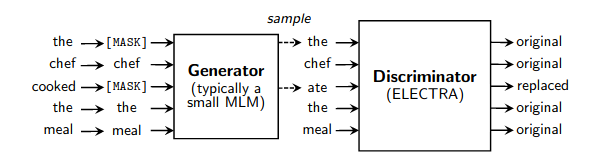

Electra는 이러한 단점을 해결하기 위해 입력 문장의 일부 토큰을 MLM 모델(Generator)을 사용하여 다른 토큰으로 대체하고, Electra 모델(Discriminator)은 주어진 문장의 토큰이 원래 토큰인지, 대체된 토큰인지 판별하는 방식으로 학습된다. <br>
Electra는 약 15%의 마스킹된 토큰에 대해서만 그래디언트를 계산하는 Bert와 달리, 입력 문장의 모든 토큰에 대해 학습하기 때문에 연산량 대비 더 높은 성능의 언어 모델을 pretrain 할 수 있다. Electra에 사용되는 MLM 모델이 Bert와 같은 사이즈라면 당연히 연산량을 줄일 수 없기 때문에, electra에서 generator로 사용되는 mlm 모델은 bert와 같은 구조이지만 훨씬 적은 수의 파라미터를 갖는다.

Electra는 Generator와 Discriminator라는 신경망을 사용하긴 하지만 GAN과는 다르다. GAN의 경우 Discriminator는 Generator가 생성한 샘플은 무조건 Fake로 구분하도록 학습되지만 Electra의 경우는 Generator가 생성한 토큰이 기존 입력 문장의 토큰과 동일하면 replaced로 취급하지 않고 original로 취급한다. <br>

Electra와 GAN의 차이점
- Generator가 기존 문장과 동일한 토큰을 생성하면 GAN은 fake로 취급하지만 electra에서는 original로 취급한다.
- 따라서 Generator가 학습 될 때 adversarial하게 학습되는 것이 아니고 maximum likelihood로 학습된다.
- Adversarial하게 학습하도록 강화학습을 사용해 논문 저자들이 구현해 보았으나 maximum likelihood 방법보다 성능이 나빴다.


### Weight sharing
Generator와 Discriminator 모두 트랜스포머 구조를 사용하므로 둘 사이의 가중치를 공유하는 weight sharing 기법을 사용하여 학습 효율 향상이 가능하다. 그러나 둘 사이에서 모든 가중치를 공유하려면 두 모델의 구조가 동일해야 하고, 큰 사이즈의 MLM 모델을 학습해야 하므로 오히려 학습에 필요한 연산량이 많아질 수 있다. <br>
논문의 저자는 모든 가중치를 공유하는 방법과 임베딩의 가중치만 공유하는 방법을 각각 테스트했는데, 모든 가중치를 공유한 경우 성능이 더 좋았지만 generator와 discriminator를 같은 크기로 사용해야 한다는 제약 때문에 임베딩의 가중치만 공유하였다고 한다. <br>
Electra에서 discriminator보다 작은 크기의 generator를 사용하는 것은 또 다른 이점이 있었다. Generator의 크기가 크고 성능이 너무 좋으면 discriminator가 original/fake 토큰을 구별하는 것이 너무 어려워져 계산량 대비 성능이 저하될 수 있는 문제가 있기 때문이다. 또한 discriminator가 실제 언어의 분포를 학습하는 것이 아니라 Generator를 모델링해 버리는 문제가 생길 수도 있다고 저자들이 밝혔다.

In [ ]:
#electra_pytorch.py
'''Electra의 forward 함수에 대한 설명'''
class Electra(nn.Module):
    def __init__(
        self,
        generator,
        discriminator,
        *,
        num_tokens = None,
        discr_dim = -1,
        discr_layer = -1,
        mask_prob = 0.15,
        replace_prob = 0.85,
        random_token_prob = 0.,
        mask_token_id = 2,
        pad_token_id = 0,
        mask_ignore_token_ids = [],
        disc_weight = 50.,
        gen_weight = 1.,
        temperature = 1.):
        super().__init__()

        self.generator = generator
        self.discriminator = discriminator

        if discr_dim > 0:
            self.discriminator = nn.Sequential(
                HiddenLayerExtractor(discriminator, layer = discr_layer),
                nn.Linear(discr_dim, 1)
            )

        # mlm related probabilities
        self.mask_prob = mask_prob
        self.replace_prob = replace_prob

        self.num_tokens = num_tokens
        self.random_token_prob = random_token_prob

        # token ids
        self.pad_token_id = pad_token_id
        self.mask_token_id = mask_token_id
        self.mask_ignore_token_ids = set([*mask_ignore_token_ids, pad_token_id])

        # sampling temperature
        self.temperature = temperature

        # loss weights
        self.disc_weight = disc_weight
        self.gen_weight = gen_weight


    def forward(self, input, **kwargs):
        b, t = input.shape

        replace_prob = prob_mask_like(input, self.replace_prob)

        # do not mask [pad] tokens, or any other tokens in the tokens designated to be excluded ([cls], [sep])
        # also do not include these special tokens in the tokens chosen at random
        '''no_mask : 패딩, cls, sep 등 마스킹되지 않아야 하는 토큰들의 위치
           mask : no_mask에 해당하는 위치를 제외하고 mask_prob의 확률로 무작위로 마스킹하는 마스크'''
        no_mask = mask_with_tokens(input, self.mask_ignore_token_ids)
        mask = get_mask_subset_with_prob(~no_mask, self.mask_prob)

        # get mask indices
        mask_indices = torch.nonzero(mask, as_tuple=True)

        # mask input with mask tokens with probability of `replace_prob` (keep tokens the same with probability 1 - replace_prob)
        masked_input = input.clone().detach()
        
        '''Generator (MLM)의 label을 생성한다'''
        # set inverse of mask to padding tokens for labels
        gen_labels = input.masked_fill(~mask, self.pad_token_id)

        # clone the mask, for potential modification if random tokens are involved
        # not to be mistakened for the mask above, which is for all tokens, whether not replaced nor replaced with random tokens
        masking_mask = mask.clone()

        # if random token probability > 0 for mlm
        if self.random_token_prob > 0:
            assert self.num_tokens is not None, 'Number of tokens (num_tokens) must be passed to Electra for randomizing tokens during masked language modeling'

            random_token_prob = prob_mask_like(input, self.random_token_prob)
            random_tokens = torch.randint(0, self.num_tokens, input.shape, device=input.device)
            random_no_mask = mask_with_tokens(random_tokens, self.mask_ignore_token_ids)
            random_token_prob &= ~random_no_mask
            masked_input = torch.where(random_token_prob, random_tokens, masked_input)

            # remove random token prob mask from masking mask
            masking_mask = masking_mask & ~random_token_prob

        # [mask] input
        masked_input = masked_input.masked_fill(masking_mask * replace_prob, self.mask_token_id)
        
        '''마스킹된 문장을 generator에 입력하고 출력을 얻는다.
           위에서 생성한 gen_labels와 비교하여 cross entropy loss(mlm_loss)를 계산한다.'''
        # get generator output and get mlm loss
        logits = self.generator(masked_input, **kwargs)

        mlm_loss = F.cross_entropy(
            logits.transpose(1, 2),
            gen_labels,
            ignore_index = self.pad_token_id
        )
        '''sampled : Generator가 생성한 토큰'''
        # use mask from before to select logits that need sampling
        sample_logits = logits[mask_indices]
        
        # sample
        sampled = gumbel_sample(sample_logits, temperature = self.temperature)
        '''입력 문장에서 마스킹된 위치를 generator가 생성한 토큰인 sampled로 대체한다.'''
        # scatter the sampled values back to the input
        disc_input = input.clone()
        disc_input[mask_indices] = sampled.detach()
        '''원본 문장과 discriminator에 입력되는 문장에서 서로 다른 토큰을 True, 같은 토큰은 False로 라벨링한다.'''
        # generate discriminator labels, with replaced as True and original as False
        disc_labels = (input != disc_input).float().detach()
        
        # get discriminator predictions of replaced / original
        non_padded_indices = torch.nonzero(input != self.pad_token_id, as_tuple=True)
        '''일부 토큰이 Generator에 의해 대체된 문장인 disc_input을 discriminator에 입력해 출력을 얻고 binary cross entropy loss를 계산한다.
           discriminator는 토큰이 대체되었는지 아닌지 구분하는 역할이므로 BCE loss를 사용한다.'''
        # get discriminator output and binary cross entropy loss
        disc_logits = self.discriminator(disc_input, **kwargs)
        disc_logits = disc_logits.reshape_as(disc_labels)

        disc_loss = F.binary_cross_entropy_with_logits(
            disc_logits[non_padded_indices],
            disc_labels[non_padded_indices]
        )

        # gather metrics
        with torch.no_grad():
            gen_predictions = torch.argmax(logits, dim=-1)
            disc_predictions = torch.round((torch.sign(disc_logits) + 1.0) * 0.5)
            gen_acc = (gen_labels[mask] == gen_predictions[mask]).float().mean()
            disc_acc = 0.5 * (disc_labels[mask] == disc_predictions[mask]).float().mean() + 0.5 * (disc_labels[~mask] == disc_predictions[~mask]).float().mean()
        
        '''계산된 loss를 반환한다.'''
        # return weighted sum of losses
        return Results(self.gen_weight * mlm_loss + self.disc_weight * disc_loss, mlm_loss, disc_loss, gen_acc, disc_acc, disc_labels, disc_predictions)

In [1]:
'''pretrain.py의 train 함수 일부 해설'''
def train(rank, args):

    from transformers import AutoConfig, ElectraForMaskedLM, ElectraForPreTraining
    '''Generator와 Discriminator를 정의한다.
       각각 huggingface의 transformers 패키지에서 ElectraForMaskedLM을 generator로 사용했고 
       ElectraForPreTraining을 discriminator로 사용했다.'''
    generator = ElectraForMaskedLM(AutoConfig.from_pretrained(args.model_generator))
    discriminator = ElectraForPreTraining(AutoConfig.from_pretrained(args.model_discriminator))

    tie_weights(generator, discriminator)

    model = to_distributed_model(Electra(
        LogitsAdapter(generator),
        LogitsAdapter(discriminator),
        num_tokens = vocab_size,
        mask_token_id = mask_token_id,
        pad_token_id = pad_token_id,
        mask_prob = args.model_mask_prob,
        mask_ignore_token_ids = [tokenizer.vocab['[CLS]'], tokenizer.vocab['[SEP]']],
        random_token_prob = 0.0).to(device))


    #######################
    ## optimizer
    '''warmup이 포함된 옵티마이저 생성'''
    def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
        def lr_lambda(current_step):
            learning_rate = max(0.0, 1. - (float(current_step) / float(num_training_steps)))
            learning_rate *= min(1.0, float(current_step) / float(num_warmup_steps))
            return learning_rate
        return LambdaLR(optimizer, lr_lambda, last_epoch)

    def get_params_without_weight_decay_ln(named_params, weight_decay):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {
                'params': [p for n, p in named_params if not any(nd in n for nd in no_decay)],
                'weight_decay': weight_decay,
            },
            {
                'params': [p for n, p in named_params if any(nd in n for nd in no_decay)],
                'weight_decay': 0.0,
            },
        ]
        return optimizer_grouped_parameters

    optimizer = torch.optim.AdamW(get_params_without_weight_decay_ln(model.named_parameters(), weight_decay=0.1), lr=args.opt_lr, betas=(0.9, 0.999), eps=1e-08)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args.opt_warmup_steps, num_training_steps=args.opt_num_training_steps)
    scaler = torch.cuda.amp.GradScaler(enabled=args.gpu_mixed_precision)


    #######################
    ## train

    t, steps_s, eta_m = time(), 0., 0

    for step in range(args.opt_num_training_steps+1):
        input_ids, input_mask, segment_ids = next(ds_train_loader)

        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)

        assert input_ids.shape[1] <= args.data_max_seq_length

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=args.gpu_mixed_precision):
            '''모델에 입력 문장과 마스크를 입력하여 loss를 반환받는다.'''
            loss, loss_mlm, loss_disc, acc_gen, acc_disc, disc_labels, disc_pred = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids)
        '''옵티마이저를 사용해 오차역전파를 하는 부분'''
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        metrics = {
            'step': (step, '{:8d}'),
            'loss': (loss.item(), '{:8.5f}'),
            'loss_mlm': (loss_mlm.item(), '{:8.5f}'),
            'loss_disc': (loss_disc.item(), '{:8.5f}'),
            'acc_gen': (acc_gen.item(), '{:5.3f}'),
            'acc_disc': (acc_disc.item(), '{:5.3f}'),
            'lr': (scheduler.get_last_lr()[0], '{:8.7f}'),
            'steps': (steps_s, '{:4.1f}/s'),
            'eta': (eta_m, '{:4d}m'),
        }

        if step % args.step_log == 0:
            sep = ' ' * 2
            logger.info(sep.join([f'{k}: {v[1].format(v[0])}' for (k, v) in metrics.items()]))

        if step > 0 and step % 100 == 0:
            t2 = time()
            steps_s = 100. / (t2 - t)
            eta_m = int(((args.opt_num_training_steps - step) / steps_s) // 60)
            t = t2

        if step % 200 == 0:
            logger.info(np.array2string(disc_labels[0].cpu().numpy(), threshold=sys.maxsize, max_line_width=sys.maxsize))
            logger.info(np.array2string(disc_pred[0].cpu().numpy(), threshold=sys.maxsize, max_line_width=sys.maxsize))

        if step > 0 and step % args.step_ckpt == 0 and is_master:
            '''pretrained 모델을 저장'''
            discriminator.electra.save_pretrained(f'{args.output_dir}/ckpt/{step}')


## Fine Tuning

In [2]:
try:
    import transformers, soynlp, pytorch_lightning
except:
    !pip install -U -q transformers soynlp pytorch-lightning
!pip install emoji==0.6.0

     |████████████████████████████████| 5.8 MB 4.7 MB/s 
     |████████████████████████████████| 416 kB 100.4 MB/s 
     |████████████████████████████████| 798 kB 86.8 MB/s 
     |████████████████████████████████| 182 kB 96.6 MB/s 
     |████████████████████████████████| 7.6 MB 94.0 MB/s 
     |████████████████████████████████| 125 kB 103.4 MB/s 
     |████████████████████████████████| 512 kB 97.2 MB/s 
     |████████████████████████████████| 87 kB 9.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 3.1 MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49735 sha256=07ac507f9303d0617a891500569f3fe5d0ab1eae4176a3a8a2a266a480745565
  Stored in directory: /root/.cache/pip/wheels/43/3d/82/e7baffa5e86346c6178d7750dba6e8ef063282a37fc563f8f8
Successfully built emoji


In [3]:
import os

if not os.path.exists('./nsmc'):
    !git clone https://github.com/e9t/nsmc

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 24.69 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [4]:
!head nsmc/ratings_train.txt

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1


# 패키지 import & 기본 Args 설정

In [5]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

## 기본 학습 Arguments

In [6]:
args = {
    'random_seed': 42, # Random Seed
    'pretrained_model': 'beomi/KcELECTRA-base',  # Transformers PLM name
    'pretrained_tokenizer': '',  # Optional, Transformers Tokenizer Name. Overrides `pretrained_model`
    'batch_size': 32,
    'lr': 5e-6,  # Starting Learning Rate
    'epochs': 1,  # Max Epochs
    'max_length': 150,  # Max Length input size
    'train_data_path': "nsmc/ratings_train.txt",  # Train Dataset file 
    'val_data_path': "nsmc/ratings_test.txt",  # Validation Dataset file 
    'test_mode': False,  # Test Mode enables `fast_dev_run`
    'optimizer': 'AdamW',  # AdamW vs AdamP
    'lr_scheduler': 'exp',  # ExponentialLR vs CosineAnnealingWarmRestarts
    'fp16': True,  # Enable train on FP16(if GPU)
    'tpu_cores': 0,  # Enable TPU with 1 core or 8 cores
    'cpu_workers': os.cpu_count(),
}

In [7]:
args

{'random_seed': 42,
 'pretrained_model': 'beomi/KcELECTRA-base',
 'pretrained_tokenizer': '',
 'batch_size': 32,
 'lr': 5e-06,
 'epochs': 1,
 'max_length': 150,
 'train_data_path': 'nsmc/ratings_train.txt',
 'val_data_path': 'nsmc/ratings_test.txt',
 'test_mode': False,
 'optimizer': 'AdamW',
 'lr_scheduler': 'exp',
 'fp16': True,
 'tpu_cores': 0,
 'cpu_workers': 12}

# Model 만들기 with Pytorch Lightning

In [8]:
!nvidia-smi

Wed Dec  7 03:36:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
class Model(LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters() # 이 부분에서 self.hparams에 위 kwargs가 저장된다.
        
        self.clsfier = AutoModelForSequenceClassification.from_pretrained(self.hparams.pretrained_model)
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.hparams.pretrained_tokenizer
            if self.hparams.pretrained_tokenizer
            else self.hparams.pretrained_model
        )

    def forward(self, **kwargs):
        return self.clsfier(**kwargs)

    def step(self, batch, batch_idx):
        data, labels = batch
        output = self(input_ids=data, labels=labels)

        # Transformers 4.0.0+
        loss = output.loss
        logits = output.logits

        preds = logits.argmax(dim=-1)

        y_true = list(labels.cpu().numpy())
        y_pred = list(preds.cpu().numpy())

        return {
            'loss': loss,
            'y_true': y_true,
            'y_pred': y_pred,
        }

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def epoch_end(self, outputs, state='train'):
        loss = torch.tensor(0, dtype=torch.float)
        for i in outputs:
            loss += i['loss'].cpu().detach()
        loss = loss / len(outputs)

        y_true = []
        y_pred = []
        for i in outputs:
            y_true += i['y_true']
            y_pred += i['y_pred']
        
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        self.log(state+'_loss', float(loss), on_epoch=True, prog_bar=True)
        self.log(state+'_acc', acc, on_epoch=True, prog_bar=True)
        self.log(state+'_precision', prec, on_epoch=True, prog_bar=True)
        self.log(state+'_recall', rec, on_epoch=True, prog_bar=True)
        self.log(state+'_f1', f1, on_epoch=True, prog_bar=True)
        print(f'[Epoch {self.trainer.current_epoch} {state.upper()}] Loss: {loss}, Acc: {acc}, Prec: {prec}, Rec: {rec}, F1: {f1}')
        return {'loss': loss}
    
    def training_epoch_end(self, outputs):
        self.epoch_end(outputs, state='train')

    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs, state='val')

    def configure_optimizers(self):
        if self.hparams.optimizer == 'AdamW':
            optimizer = AdamW(self.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == 'AdamP':
            from adamp import AdamP
            optimizer = AdamP(self.parameters(), lr=self.hparams.lr)
        else:
            raise NotImplementedError('Only AdamW and AdamP is Supported!')
        if self.hparams.lr_scheduler == 'cos':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
        elif self.hparams.lr_scheduler == 'exp':
            scheduler = ExponentialLR(optimizer, gamma=0.5)
        else:
            raise NotImplementedError('Only cos and exp lr scheduler is Supported!')
        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
        }

    def read_data(self, path):
        if path.endswith('xlsx'):
            return pd.read_excel(path)
        elif path.endswith('csv'):
            return pd.read_csv(path)
        elif path.endswith('tsv') or path.endswith('txt'):
            return pd.read_csv(path, sep='\t')
        else:
            raise NotImplementedError('Only Excel(xlsx)/Csv/Tsv(txt) are Supported')

    def clean(self, x):
        emojis = ''.join(emoji.UNICODE_EMOJI.keys())
        pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-힣{emojis}]+')
        url_pattern = re.compile(
            r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
        x = pattern.sub(' ', x)
        x = url_pattern.sub('', x)
        x = x.strip()
        x = repeat_normalize(x, num_repeats=2)
        return x

    def encode(self, x, **kwargs):
        return self.tokenizer.encode(
            self.clean(str(x)),
            padding='max_length',
            max_length=self.hparams.max_length,
            truncation=True,
            **kwargs,
        )

    def preprocess_dataframe(self, df):
        df['document'] = df['document'].map(self.encode)
        return df

    def dataloader(self, path, shuffle=False):
        df = self.read_data(path)
        df = self.preprocess_dataframe(df)

        dataset = TensorDataset(
            torch.tensor(df['document'].to_list(), dtype=torch.long),
            torch.tensor(df['label'].to_list(), dtype=torch.long),
        )
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size * 1 if not self.hparams.tpu_cores else self.hparams.tpu_cores,
            shuffle=shuffle,
            num_workers=self.hparams.cpu_workers,
        )

    def train_dataloader(self):
        return self.dataloader(self.hparams.train_data_path, shuffle=True)

    def val_dataloader(self):
        return self.dataloader(self.hparams.val_data_path, shuffle=False)


In [10]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename='epoch{epoch}-val_acc{val_acc:.4f}',
    monitor='val_acc',
    save_top_k=3,
    mode='max',
    auto_insert_metric_name=False,
)

In [11]:
!nvidia-smi

Wed Dec  7 03:36:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 학습 (감성분석)

In [12]:
print("Using PyTorch Ver", torch.__version__)
print("Fix Seed:", args['random_seed'])
seed_everything(args['random_seed'])
model = Model(**args)

print(":: Start Training ::")
trainer = Trainer(
    callbacks=[checkpoint_callback],
    max_epochs=args['epochs'],
    fast_dev_run=args['test_mode'],
    num_sanity_val_steps=None if args['test_mode'] else 0,
    # For GPU Setup
    deterministic=torch.cuda.is_available(),
    gpus=[0] if torch.cuda.is_available() else None,  # 0번 idx GPU  사용
    precision=16 if args['fp16'] and torch.cuda.is_available() else 32,
    # For TPU Setup
    # tpu_cores=args['tpu_cores'] if args['tpu_cores'] else None,
)
trainer.fit(model)

INFO:lightning_lite.utilities.seed:Global seed set to 42


Using PyTorch Ver 1.12.1+cu113
Fix Seed: 42


Downloading:   0%|          | 0.00/504 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.ou

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/396k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


:: Start Training ::


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/optimizer.py:382: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'scheduler'}
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                             | Params
-------------------------------------------------------------
0 | clsfier | ElectraForSequenceClassification | 124 M 
-------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
249.093   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[Epoch 0 VAL] Loss: 0.22432200610637665, Acc: 0.90912, Prec: 0.8929183650146661, Rec: 0.9311563977277242, F1: 0.9116365899191039
[Epoch 0 TRAIN] Loss: 0.27716562151908875, Acc: 0.88166, Prec: 0.8800506059395392, Rec: 0.883143784997394, F1: 0.8815944822801951


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


# Inference

In [13]:
from glob import glob

latest_ckpt = sorted(glob('./lightning_logs/version_0/checkpoints/*.ckpt'))[-1]
latest_ckpt

'./lightning_logs/version_0/checkpoints/epoch0-val_acc0.9091.ckpt'

In [14]:
model = Model.load_from_checkpoint(latest_ckpt)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.ou

In [15]:
def infer(x):
    return torch.softmax(
        model(**model.tokenizer(x, return_tensors='pt')
    ).logits, dim=-1)

## Inference 결과
감성분석 태스크를 잘 수행하는 것을 확인하였다.

In [16]:
infer('이 영화 노잼 ㅡㅡ')

tensor([[0.9279, 0.0721]], grad_fn=<SoftmaxBackward0>)

In [17]:
infer('이  영화  꿀잼! 완존  추천요  ')

tensor([[0.2418, 0.7582]], grad_fn=<SoftmaxBackward0>)